### Preparing the data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Modules:

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tkl
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization, Activation, Add, ZeroPadding2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random
from itertools import chain

### Creating a list of file names:

In [3]:
source_path = '/content/drive/MyDrive/HighResolution/'

filenames = []
folder_names = ['62000', '63000', '64000', '65000', '66000', '67000', '68000', '69000']
# test = os.path.join(source_path, f'{folder_names[1]}')
# content = os.listdir(test)

# print(content)
for folder in folder_names:
  
    filenames.append(glob.glob(os.path.join(source_path, f'{folder}/*.png')))

filenames = list(chain.from_iterable(filenames))
random.shuffle(filenames)
print('Completed.')

Completed.


### Length of filenames:

In [4]:
print(len(filenames))


8000


### Showing a sample:

/content/drive/MyDrive/HighResolution/68000/68371.png


Text(0.5, 1.0, 'Noisy')

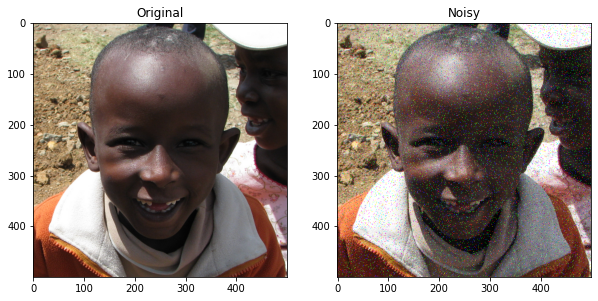

In [5]:
img_path = filenames[1001]
print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500, 500))
noisy = random_noise(img, mode = 's&p', amount=0.05)
fig, ax = plt.subplots(1, 2, figsize = (10,12))
ax[0].imshow(img)
ax[0].set_title('Original')
ax[1].imshow(noisy)
ax[1].set_title('Noisy')

### Creating train set and test set:

In [6]:
test_filenames = filenames[-2001:-1]
del filenames[-2001:-1]
train_filenames = filenames
print(f'Size of training set is: {len(train_filenames)}', end='\n----------------------------\n')
print(f'Size of test set is: {len(test_filenames)}', end='\n----------------------------\n')

Size of training set is: 6000
----------------------------
Size of test set is: 2000
----------------------------


### Train set and validation set:

In [7]:
train_img, val_img, _, _ = train_test_split(train_filenames, train_filenames, test_size = 0.2, shuffle = True, random_state = 0)

In [8]:
print(f'Size of training set is: {len(train_img)}', end='\n----------------------------\n')
print(f'Size of validation set is: {len(val_img)}', end='\n----------------------------\n')
print(f'Total: {len(train_img) + len(val_img)}')

Size of training set is: 4800
----------------------------
Size of validation set is: 1200
----------------------------
Total: 6000


### Determining important variables:

In [9]:
WIDTH = 512
HEIGHT = 512
n_channels = 3
BATCH_SIZE = 32

### Data generation:

In [10]:
class  DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, orig_filenames, batch_size = 32, shuffle = True):
        self.orig_filenames = orig_filenames
        self.noisy_filenames = orig_filenames
        self.filenames = list(zip(self.orig_filenames, self.noisy_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
    
    def __len__(self):
        return (len(self.orig_filenames) // self.batch_size)
    
    def __getitem__(self, idx):
        batch = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, Y = self.__data_generation(batch)

        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.orig_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch):
        orig = []
        noisy = []
        
        for orig_file, _ in batch:
          image = cv2.imread(orig_file)
          image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          image_noisy = cv2.resize(image, (WIDTH, HEIGHT))
          image_orig = cv2.resize(image, (256,256))
          image_orig = tf.expand_dims(image_orig, axis=0)
          # print(f'noisy set shape: {image_noisy.shape} ... orig set shape: {image_orig.shape}')
          orig.append(image)
          noisy.append(self.make_noisy(image))
          
        return  np.array(noisy), np.array(orig)

    def make_noisy(self, image):
      image_ = image
      noisy_image = random_noise(image_, mode = 's&p', amount=0.05)
      
      return noisy_image

### Generating training set and validation set:

In [11]:
train_generator = DataGenerator(train_img, BATCH_SIZE)
val_generator = DataGenerator(val_img, BATCH_SIZE)

### Creating the model architecture (U-net):

In [12]:
def resnet(input= None, n_filters=64, kernel_size=(3,3), padding='same', stride=1):
    pad = ZeroPadding2D((3,3))(input)
    conv = Conv2D(64, (7,7), strides=2)(pad)
    conv = Activation('relu')(conv)
    # conv = BatchNormalization()(conv)
    skip0 = conv    #256, 256, 64
    print(f'Skip0 dimensions is: {skip0}')
    conv = ZeroPadding2D((1,1))(conv)
    out0 = MaxPooling2D(pool_size=(3,3), strides=2)(conv)   # 128, 128, 64
    print(f'out0 dimensions is: {out0}')

    # -------

    # block1:
    conv = ZeroPadding2D((1,1))(out0)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    # conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(64, (3,3), strides=1)(conv)
    # conv = BatchNormalization()(conv)
    out1 = Add()([conv, out0])    # 128, 128, 64
    print(f'out1 dimensions is: {out1}')

    conv = ZeroPadding2D((1,1))(out1)
    conv = Conv2D(128, (3,3), strides=2)(conv)
    # conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    # conv = BatchNormalization()(conv)
    temp_out = Conv2D(128, (1,1), strides=2)(out1)
    out = Add()([conv, temp_out]) 
    skip1 = out       # 64, 64, 128
    print(f'Skip1 dimensions is: {skip1}')
    out4 = MaxPooling2D(pool_size=(2,2), strides=2)(out) #32, 32, 128
    print(f'out4 dimensions is: {out4}')

    conv = ZeroPadding2D((1,1))(out4)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    # conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(128, (3,3), strides=1)(conv)
    # conv = BatchNormalization()(conv) 
    out5 = Add()([conv, out4])     # 32, 32, 128
    print(f'out5 dimensions is: {out5}')


    # block3

    conv = ZeroPadding2D((1,1))(out5)
    conv = Conv2D(256, (3,3), strides=2)(conv) 
    # conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), strides=1)(conv)
    # conv = BatchNormalization()(conv)
    temp_out = Conv2D(256, (1,1), strides=2)(out5)
    out = Add()([conv, temp_out])
    skip2 = out     # 16, 16, 256
    print(f'Skip2 dimensions is: {skip2}')
    out8 = MaxPooling2D(pool_size=(2,2), strides=2)(out) 
    # out8 = out # 16, 16, 256
    print(f'out8 dimensions is: {out8}')
   # 1

    # conv = BatchNormalization()(out15)
    conv = Activation('relu')(out8) 

    # print(out16)
    # conv = tkl.Dropout(0.2)(conv)
    # conv = BatchNormalization()(out16)    
    skip3 = conv    # 16, 16, 256
    print(f'Skip3 dimensions is: {skip3}')
    # conv = ZeroPadding2D((1,1))(conv)
    conv = Conv2D(256, (3,3), padding='same')(conv)
    # conv = Activation('relu')(conv) 
    # conv = Conv2D(256, (3,3), padding='same')(conv)
    conv = Activation('relu')(conv)     # 8, 8, 256
    print(f'Connnnnnnnnnv: {conv}')

    return skip0, skip1, skip2, skip3, conv


input_shape = (WIDTH, HEIGHT, n_channels)
input_img = Input(input_shape, name='image')
skip0, skip1, skip2, skip3, conv = resnet(input_img)

Skip0 dimensions is: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 64), dtype=tf.float32, name=None), name='activation/Relu:0', description="created by layer 'activation'")
out0 dimensions is: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")
out1 dimensions is: KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='add/add:0', description="created by layer 'add'")
Skip1 dimensions is: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name=None), name='add_1/add:0', description="created by layer 'add_1'")
out4 dimensions is: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
out5 dimensions is: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float

In [13]:
def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return (pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2)
    elif scale == 3:
        x = upsample_1(x, 3)
    elif scale == 4:
        x = upsample_1(x, 4)

    return x


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


ups1 = upsample(conv, 2, 256)
print('ups1:', ups1)
stack1 = concatenate([skip2, ups1])
# print(f'stack1: {stack1}')
# enc = tkl.Dropout(0.2)(stack1)
# enc = BatchNormalization()(conv)
enc = Conv2D(128, (3,3), padding='same')(stack1)
enc = Activation('relu')(enc)
# enc = tkl.Dropout(0.2)(enc)
enc = Conv2D(128, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
print(f'enc0: {enc}')

# enc = Activation('relu')(enc)

#2

ups2 = upsample(enc, 2, 128)
print('ups2:', ups2)
# stack2 = concatenate([skip1, ups2])
# conv = tkl.Dropout(0.2)(ups2)
# enc = BatchNormalization()(conv)
enc = Conv2D(64, (3,3), padding='same')(ups2)
enc = Activation('relu')(enc)
enc = Conv2D(64, (3,3), padding='same')(enc)
# enc = Activation('relu')(enc)
enc = Activation('relu')(enc)
print('enc1:', enc)
#3

ups3 = upsample(enc, 2, 32)
print('ups3:', ups3)
# stack3 = concatenate([skip1, ups3])
enc = tkl.Dropout(0.2)(ups3)
# enc = BatchNormalization()(conv)
enc = Conv2D(32, (3,3), padding='same')(enc)
enc = Activation('relu')(enc)
enc = Conv2D(32, (3,3), padding='same')(enc)
# enc = Activation('relu')(enc)
enc = Activation('relu')(enc)
print('enc2:', enc)
#4

ups4 = upsample(enc, 2, 16)
print('ups4:', ups4)
# stack4 = concatenate([skip0, ups4])
# enc = BatchNormalization()(conv)
# enc = tkl.Dropout(0.2)(stack4)
enc = Conv2D(16, (3,3), padding='same')(ups4)
enc = Activation('relu')(enc)
# enc = tkl.Dropout(0.2)(enc)
enc = Conv2D(16, (3,3), padding='same')(enc)

# enc = Activation('relu')(enc)
# enc = Activation('relu')(enc)
print('enc3:', enc)
#5

ups5 = upsample(enc, 2, 3)
# stack5 = concatenate([skip0, ups5])
# enc = tkl.Dropout(0.2)(stack5)
# enc = Conv2D(99, (3,3), padding='same')(enc)
# enc = Activation('relu')(enc)
# enc = tkl.Dropout(0.2)(conv)
# enc = Conv2D(96, (3,3), padding='same')(enc)

enc = Activation('relu')(ups5)
output = Conv2D(3, (1,1), activation='sigmoid')(enc)


print(output)


model = tf.keras.Model(inputs = [input_img], outputs = [output])

ups1: KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='tf.nn.depth_to_space/DepthToSpace:0', description="created by layer 'tf.nn.depth_to_space'")
enc0: KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 128), dtype=tf.float32, name=None), name='activation_8/Relu:0', description="created by layer 'activation_8'")
ups2: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='tf.nn.depth_to_space_1/DepthToSpace:0', description="created by layer 'tf.nn.depth_to_space_1'")
enc1: KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 64), dtype=tf.float32, name=None), name='activation_10/Relu:0', description="created by layer 'activation_10'")
ups3: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 32), dtype=tf.float32, name=None), name='tf.nn.depth_to_space_2/DepthToSpace:0', description="created by layer 'tf.nn.depth_to_space_2'")
enc2: KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 32), 

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['image[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### Compiling the model:

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

# optim_edsr = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5]))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

### Training the model:

In [ ]:
history = model.fit(train_generator,
                    validation_data = val_generator,
                    use_multiprocessing = True,
                    workers = 6, epochs=10)

Epoch 1/10


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [ ]:
model.save('1024_Denoising.h5')

### Testing the model on the test set:

In [ ]:
# path = '/kaggle/input/stanford-cars-dataset/cars_test/cars_test/'
# print(len(test_data))
evaluation_set = test_filenames[1]
# test_img_path = test_filenames[104]
# test_img = cv2.imread(test_img_path)
# test_img = cv2.resize(test_img, (WIDTH, HEIGHT))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# test_img = random_noise(test_img, mode = 's&p', amount = 0.2)
# plt.imshow(test_img)
evaluation_set

'/content/gdrive/MyDrive/lfw/Milton_Wynants/Milton_Wynants_0001.jpg'

In [ ]:
eval_set = []
# for i in range(32):
#     img = cv2.imread(evaluation_set[i])
#     img = cv2.resize(img, (WIDTH, HEIGHT))
#     img = random_noise(img, mode = 's&p', amount=0.2)
#     eval_set.append(img)
# eval_set = np.array(eval_set)
# eval_set[1].shape
path = evaluation_set

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (WIDTH, HEIGHT))
img = random_noise(img, mode = 's&p', amount=0.2)
eval_set.append(img)
img = tf.expand_dims(img, axis=0)


# testst = eval_set[1][0,:,:]
# testst.shape
# tessssst = cv2.resize(eval_set[1], (256,256))
# resized_image = tf.image.resize(eval_set[1], [256, 256])
# resized_image.shape
predicted = model.predict(img)

In [ ]:
for j in range(3):
  predicted_ = cv2.resize(predicted[j*8], (500,500))
  predicted_ = cv2.cvtColor(predicted_, cv2.COLOR_BGR2RGB)
  fig, ax = plt.subplots(1,9, figsize = (20,20))
  original = cv2.imread(evaluation_set[j*8])
  original = cv2.resize(original, (500, 500))
  original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
  noisy_orig = random_noise(original, mode = 's&p', amount=0.2)
  noisy_orig = cv2.resize(noisy_orig, (500,500))
  ax[0].imshow(predicted_)
  ax[0].set_title('Predicted Image')
  ax[1].imshow(original)
  ax[1].set_title('Original Image')
  ax[2].imshow(noisy_orig)
  ax[2].set_title('Noisy Image')


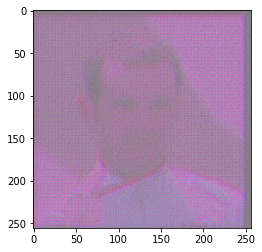

In [ ]:
predicted = tf.squeeze(predicted, axis=0)

predicted = np.array(predicted) * 255
predicted = predicted.astype(np.uint8)
# predicted = tf.image.adjust_contrast(predicted, )

plt.imshow(predicted)

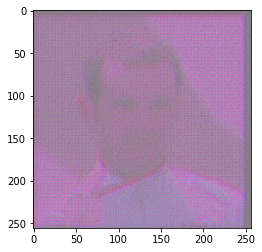

In [ ]:
# predicted = tf.squeeze(predicted, axis=0)

# predicted = np.array(predicted) * 255
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
plt.imshow(predicted)

In [ ]:
predicted.shape

(256, 256, 3)

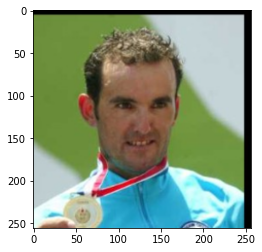

In [ ]:

test_img_path = test_filenames[1]
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (WIDTH, HEIGHT))
plt.imshow(test_img)


In [ ]:
model = tf.keras.models.load_model('/content/FaceUnetDenoising.h5')

In [ ]:
path = '/content/Abbas_Kiarostami_0001.jpg'

img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img = random_noise(img, mode = 'gaussian')
# eval_set.append(img)
img = tf.expand_dims(img, axis=0)
predicted = model.predict(img)

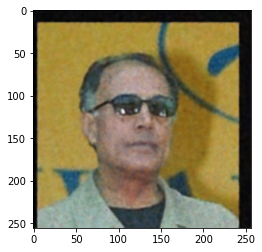

In [ ]:
predicted = tf.squeeze(predicted)
# predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
plt.imshow(predicted)

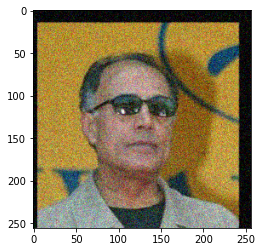

In [ ]:
img = tf.squeeze(img)

plt.imshow(img)

Text(0.5, 1.0, 'Noisy Image')

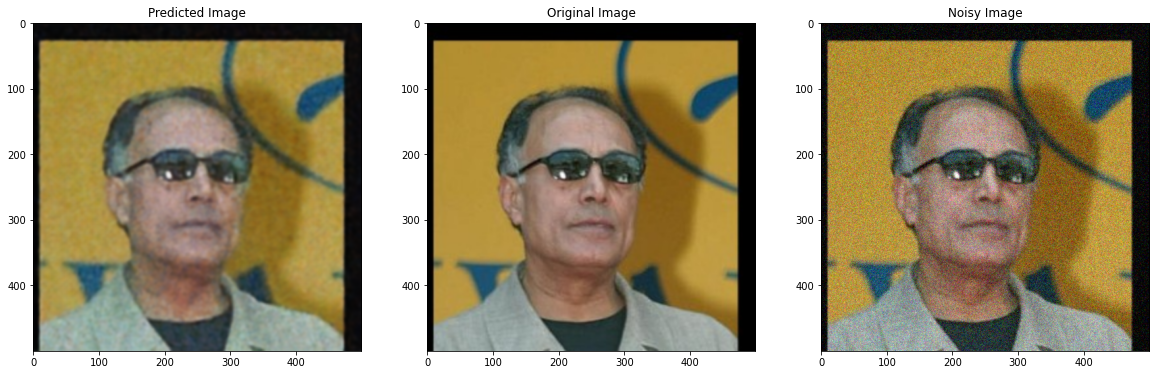

In [ ]:
# for j in range(3):
predicted = np.array(predicted)
predicted = cv2.resize(predicted, (500,500))
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,3, figsize = (20,20))
original = cv2.imread(path)
original = cv2.resize(original, (500, 500))
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
noisy_orig = random_noise(originalmode = 's&p', amount=0.2)
noisy_orig = cv2.resize(noisy_orig, (500,500))
ax[0].imshow(predicted)
ax[0].set_title('Predicted Image')
ax[1].imshow(original)
ax[1].set_title('Original Image')
ax[2].imshow(noisy_orig)
ax[2].set_title('Noisy Image')
